In [1]:
import nengo
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import scipy.stats as st
from nengo.spa import Vocabulary
from nengo.dists import UniformHypersphere
import pylab
% pylab inline

import nengo.utils.function_space
nengo.dists.Function = nengo.utils.function_space.Function
nengo.FunctionSpace = nengo.utils.function_space.FunctionSpace

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


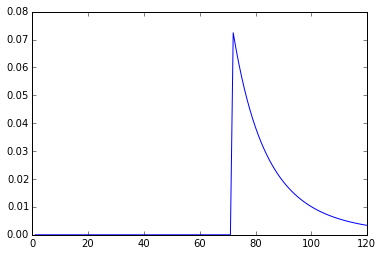

alpha_hat:  97


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [2]:

max_age = dim = 120

# likelihood parameters
# observed age data
x = 20
# x_vector = [35, 5, 20, 55, 65, 72]

# prior parameters
skew = -4
loc = 97
scale = 28

# our domain is thetas (i.e., age from 1 to 120)
thetas = np.linspace(start=1, stop=max_age, num=max_age)
alphas = np.linspace(start=1, stop=max_age, num=max_age)

def likelihood_comb(x):
    like = np.ones(max_age)
    x_vector = [x+15, x-15, x, x+35, x+45, x+52]
    for i in x_vector:
        like = np.multiply(like, likelihood(i))    
    like = like * np.power(10,12)
    return like / np.sum(like)
        

def likelihood(x):
    like = np.asarray([1/p for p in thetas])
    like[0:x-1] = [0]*np.asarray(x-1)
    return like


def p_matrix():
    p_matrix = np.zeros((len(thetas), len(alphas)))   # p(theta/alpha)
    for x in alphas:
        p_theta = [(st.skewnorm.pdf(p, a=skew, loc=x, scale=scale)) for p in thetas]
        p_theta = p_theta/np.sum(p_theta)    # normalize prior (to sum up to 1)
        p_matrix[:, x-1] = p_theta
    return p_matrix    
    

    

pylab.plot(thetas, likelihood_comb(x=x))
pylab.show()

# ----------------------------------------------------------------------------------------
# Solving for prior using empirical bayes approach computationally

comb_likelihood = likelihood_comb(x)

# declare a matrix which will store p_theta along columns for each given alpha
# theta varies along rows, and alpha varies along columns
p_mat = p_matrix()
    
# Now compute p(X/alpha) by marginalizing out theta for each alpha
#comb_likelihood = comb_likelihood/sum(comb_likelihood)  # already normalized in likelihood_comb function
#p_matrix = p_matrix/sum(p_matrix)
marginpost_set = np.dot(comb_likelihood, p_mat)   # this will be a list of dimentions (1 x max_age)  
#pick the max value and find the corresponding alpha
#print marginpost_set
alpha_hat = np.argmax(marginpost_set) + 1

print "alpha_hat: ", alpha_hat


In [ ]:
lik_space = nengo.dists.Function(likelihood_comb,
                             x=nengo.dists.Uniform(x,x))
data = lik_space.sample(200)
pylab.plot(thetas, data.T)
pylab.show()


pmatrix_space = nengo.dists.Function(p_matrix)

data = pmatrix_space.sample(50)

pylab.plot(thetas, data.T)
pylab.show()

'''
pylab.plot(alphas, data.T)
pylab.show()

from mpl_toolkits.mplot3d import Axes3D
fig = pylab.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(thetas[:,0], alphas[:,1], data.T)
pylab.show()
'''

In [ ]:
fs = nengo.FunctionSpace(nengo.dists.Function(p_matrix), n_basis=20)


model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=500, dimensions=fs.n_basis)
    ens.encoders = fs.project(fs.space)
    ens.eval_points = fs.project(fs.space)
    
    stimulus = nengo.Node(fs.project(p_matrix()))
    nengo.Connection(stimulus, ens)
    
    probe = nengo.Probe(ens, synapse=0.01)

sim = nengo.Simulator(model)
sim.run(0.2)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = pylab.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(thetas[:,0], alphas[:,1], fs.reconstruct(sim.data[probe][-1]))
pylab.show()

In [4]:
fs = nengo.FunctionSpace(nengo.dists.Function(p_matrix), n_basis=20)
lik_fs = nengo.FunctionSpace(nengo.dists.Function(likelihood_comb,
                             x=nengo.dists.Uniform(x,x)), n_basis=20)


model = nengo.Network()
with model:
    ens = nengo.networks.EnsembleArray(n_neurons=50, n_ensembles=fs.n_basis)
    ens.encoders = fs.project(fs.space)
    ens.eval_points = fs.project(fs.space)
    
    stimulus = nengo.Node(fs.project(p_matrix()))
    nengo.Connection(stimulus, ens.input)
    
    probe = nengo.Probe(ens.output, synapse=0.01)
    
    
    ens2 = nengo.networks.EnsembleArray(n_neurons=50, n_ensembles=lik_fs.n_basis)
    ens.encoders = lik_fs.project(lik_fs.space)
    ens.eval_points = lik_fs.project(lik_fs.space)
    probe2 = nengo.Probe(ens2.output, synapse=0.01)


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyboardInterrupt: 

In [ ]:
sim = nengo.Simulator(model)
sim.run(0.2)

In [ ]:
space = []
for i in range(100):
    space.append(skew_gauss(
                          skew=np.random.uniform(skew-1, skew+2), 
                          loc=np.random.uniform(loc-1,loc+2), 
                          scale=np.random.uniform(scale-1, scale+2)))
pylab.plot(thetas, np.array(space).T)
pylab.show()

lik_space = []
for i in range(100):
    lik_space.append(likelihood(x=np.random.uniform(x-1,x+2)))
pylab.plot(thetas, np.array(lik_space).T)
pylab.show()


post_space = []
for i in range(100):
    post_space.append(posterior(x=np.random.uniform(x-1,x+2),
                            skew=np.random.uniform(skew-1, skew+2), 
                          loc=np.random.uniform(loc-1,loc+2), 
                          scale=np.random.uniform(scale-1, scale+2)))
pylab.plot(thetas, np.array(post_space).T)
pylab.show()

In [ ]:
model = nengo.Network(seed=15)
with model:
    stim = nengo.Node(fs.project(skew_gauss(skew=-4, loc=97, scale=28)))
    ens = nengo.Ensemble(n_neurons=100, dimensions=fs.n_basis,
                         encoders=fs.project(space),
                         eval_points=fs.project(space))
    nengo.Connection(stim, ens)
    probe_func = nengo.Probe(ens, synapse=0.03)
sim = nengo.Simulator(model)
sim.run(0.2)
pylab.plot(thetas, fs.reconstruct(sim.data[probe_func][-1]))
pylab.figure()
pylab.imshow(fs.reconstruct(sim.data[probe_func]), extent=(-1,1,0.2,0), aspect=10.0)
pylab.ylabel('time')
pylab.show()

In [ ]:
radius = np.mean(np.linalg.norm(space.sample(100), axis=1))
print radius